In [1]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from unet import UNet
from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset
import cv2

In [14]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()

    img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        print(output.shape)
        #if net.n_classes > 1:
        #    probs = F.softmax(output, dim=1)
        #else:
        #    probs = torch.sigmoid(output)
        probs_0 = torch.sigmoid(output[:, 0, :, :])
        probs_1 = torch.sigmoid(output[:, 1, :, :])

        probs_0 = probs_0.squeeze(0)
        probs_1 = probs_1.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(full_img.width),#size[1]),
                transforms.ToTensor()
            ]
        )

        probs_0 = tf(probs_0.cpu())
        probs_1 = tf(probs_1.cpu())
        mask_0 = probs_0.squeeze().cpu().numpy()
        mask_1 = probs_1.squeeze().cpu().numpy()
        full_mask = np.array([mask_0, mask_1])#probs.squeeze().cpu().numpy()

    return full_mask# > out_threshold


In [15]:
def get_output_filenames(args):
    in_files = args.input
    out_files = []

    if not args.output:
        for f in in_files:
            pathsplit = os.path.splitext(f)
            out_files.append("{}_OUT{}".format(pathsplit[0], pathsplit[1]))
    elif len(in_files) != len(args.output):
        logging.error("Input files and output files are not of the same length")
        raise SystemExit()
    else:
        out_files = output

    return out_files

In [16]:
def mask_to_image(mask):
    return Image.fromarray((mask * 255).astype(np.uint8))

In [17]:
in_files = 'data/test_sag_mid_mult/imgs/00002.PNG'
in_masks = 'data/test_sag_mid_mult/masks/00002.PNG'
out_files = 'output.jpg'

model = 'checkpoints/CP_epoch50.pth'

net = UNet(n_channels=1, n_classes=2)

logging.info("Loading model {}".format(model))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))

logging.info("Model loaded !")

In [18]:
scale = 0.5
mask_threshold = 0.6 #минимальная вероятность для рассматривания пикселя на маску

In [19]:
no_save = True
viz = False

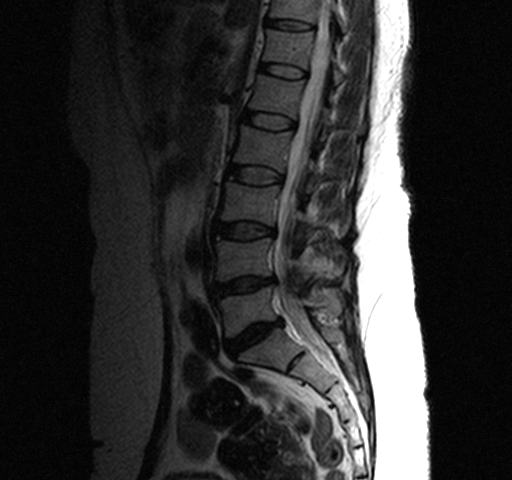

In [20]:
Image.open(in_files)

In [21]:
img = Image.open(in_files)
#img = cv2.imread(in_files)

In [105]:
mask = predict_img(net=net,
                   full_img=img,
                   scale_factor=scale,
                   out_threshold=mask_threshold,
                   device=device)

torch.Size([1, 2, 240, 256])


In [106]:
mask.shape

(2, 512, 546)

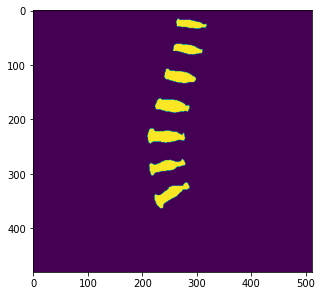

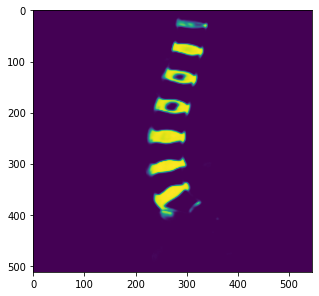

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

true_mask = cv2.imread(in_masks)
plt.figure(figsize=(5,5))
plt.imshow(true_mask[:,:,0] * 255)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(mask[0])
plt.show()

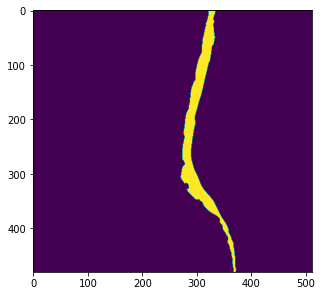

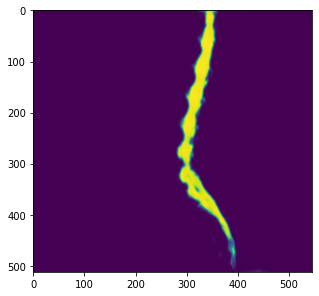

In [108]:
true_mask = cv2.imread(in_masks)
plt.figure(figsize=(5,5))
plt.imshow(true_mask[:,:,1] * 255)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(mask[1])
plt.show()

In [109]:
mask = np.array([mask[0] > 0.9, mask[1] > 0.5])

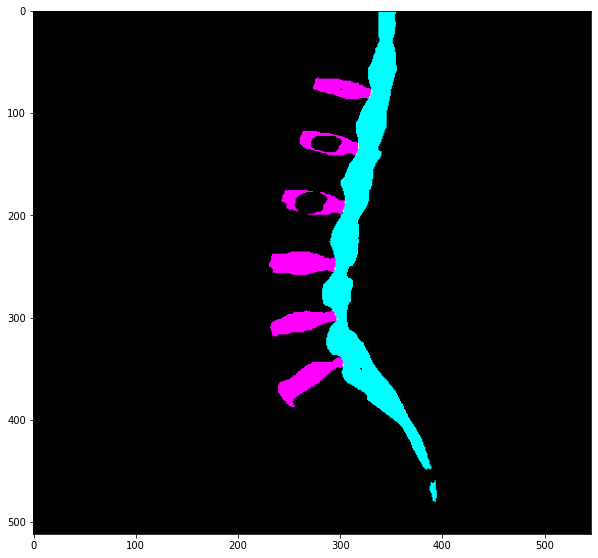

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(np.moveaxis(np.array([mask[0,:,:] * 255,
                                 mask[1,:,:] * 255,
                                 (mask[0,:,:] + mask[1,:,:]) * 255]
                               ),
                       0, 2)
          )
plt.show()

<Figure size 1440x1440 with 0 Axes>

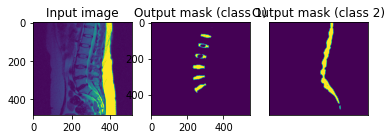

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,20))
plot_img_and_mask(img, mask)

In [112]:
np_img = np.array(img.resize((mask[0].shape[1], mask[0].shape[0]))) +100

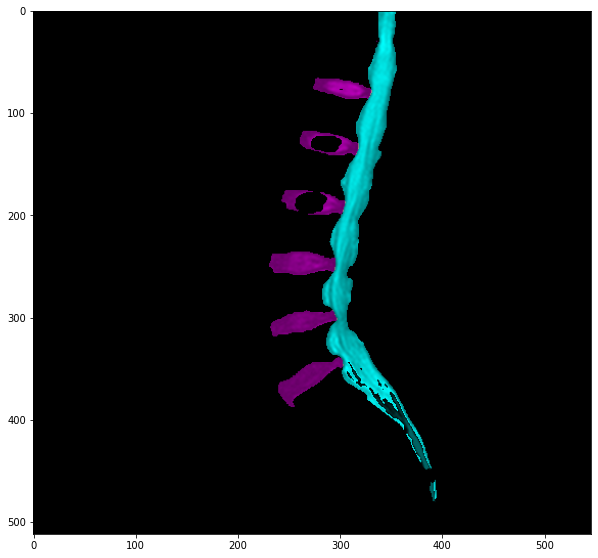

In [113]:
plt.figure(figsize=(10,10))
plt.imshow(np.moveaxis(np.array([mask[0,:,:] * np_img,
                                 mask[1,:,:] * np_img,
                                 (mask[0,:,:] + mask[1,:,:]) * np_img]
                               ),
                       0, 2)
          )
plt.show()